# Exercise 10: Stochastic Block Model

In this exercise, we will explore how we can use statistical ensembles to detect cluster structures in networks. We particularly implement the stochastic block model that has been introduced in the last lecture, and apply it to a real data set.

In [1]:
#BOILERPLATE_CODE
import numpy as np
import pathpy as pp

%matplotlib inline
import matplotlib.pyplot as plt
import scipy.special
from decimal import *
import string
from collections import Counter

### Task 1: Stochastic Block Model

Implement the stochastic block model using `python` and `pathpy`. For this, you should implement a `python` function which - for a given stochastic block matrix $\mathbf{B}$ and a fixed vector $z$ that denotes the block assignment - generates a random undirected network according to the stochastic block model.

In [2]:
#BOILERPLATE_CODE
def GenerateNetworkSBM(sbm, z, node_names=None):
    n = pp.Network()
    for i, iVal in enumerate(z):
        n.add_node(i)
    
    for i in range(len(z)):
        for j in range(i, len(z)):
            if np.random.rand() < sbm[z[i],z[j]]:
                n.add_edge(i,j)
        
    return n

Test your function using the two stochastic block matrices defined on slides 22 and 23 in lecture 10. Plot the resulting networks and color the nodes according to the block assignment vector.

In [3]:
def plot_NetworkSBM(sbm, z):
    network = GenerateNetworkSBM(sbm, z)
    z_colors = {zInd : 'red' if zVal==0 else 'blue' for zInd, zVal in enumerate(z)}
    pp.visualisation.plot(network, node_color=z_colors)

In [4]:
# p_threshold = .5
# n_nodes = 10
# z_01 = [0 if np.random.rand() < p_threshold else 1 for i in range(n_nodes)]

# *** Example on slide 17 ***
sbm_01 = np.array([[1, .1],[.1, 1]], dtype=float)
z_01 = np.array([0,0,0,1,1,1],dtype=int)
plot_NetworkSBM(sbm_01, z_01)

In [5]:
# *** Example on slide 22***
sbm_02 = np.array([[1./3, 4./9],[4./9,2./3]], dtype=float)
z_02 = np.array([0,1,0,0,1,1], dtype=int)
plot_NetworkSBM(sbm_02, z_02)

In [6]:
# *** Example on slide 23 ***
sbm_03 = np.array([[1.,1./9],[1./9,1]], dtype=float)
z_03 = np.array([0,0,0,1,1,1], dtype=int)
plot_NetworkSBM(sbm_03, z_03)

In [7]:
n_ = GenerateNetworkSBM(sbm_01, z_01)

In [8]:
for i in n_.edges:
    print(i == (1,2))

False
False
False
False
True
False
False
False
False
False
False
False


### Task 2: Inference of Stochastic Block Model

Implement a `python` function which - based on an empirical network $G_e$, a fixed number of blocks $B$, and a given block assignment vector $\vec{z}$ - computes the maximum likelihood estimate over all stochastic block matrices $\mathbf{M}$. For this purpose, you shall use the maximum likelihood function introduced on slide 20 in lecture 10.

**Hint:** You will need a logarithm definition where log(0) = 0, i.e. 0^0 = 1, i.e. where we define 0 * -Inf = 0. We define this in the following helper function:

In [9]:
#BOILERPLATE_CODE
def log2_0(x):
    if x == 0:
        return 0
    else:
        return np.log2(x)

In [10]:
#BOILERPLATE_CODE
def MaxLikelihoodSBM(g, z, node_names):
    max_like = 1.
    for l in range(len(set(z))):
        for k in range(l,len(set(z))):
            e_kl = len([i for i,j in g.edges if (z[i]==k and z[j]==l) or (z[i]==l and z[j]==k)])
            n_k = len([i for i in z if i==k])
            n_l = len([i for i in z if i==l])
            if l == k:
                n_kl = scipy.special.binom(n_k, 2)
            else:
                n_kl = n_k * n_l
            print(n_k, n_l, n_kl, e_kl)
            max_like += e_kl * log2_0(e_kl) - n_kl + (n_kl-e_kl) * log2_0(1 - e_kl/n_kl)
            
    return max_like

Test your function by inferring the communities in the example network from the lecture (e.g. slide 23 in L10). Due to the small size of the example network, you can use the naive approach of enumerating all possible block assignment vectors $\vec{z}$. Plot the likelihood for each assignment vector $\vec{z}$ as shown on slide 24.

In [11]:
g = pp.Network()
g.add_edge(0, 1) #('a', 'b')
g.add_edge(1, 2) #('b', 'c')
g.add_edge(0, 2) #('a', 'c')
g.add_edge(1, 3) #('b', 'd')
g.add_edge(3, 4) #('d', 'f')
g.add_edge(3, 5) #('d', 'e')
g.add_edge(4, 5) #('e', 'f')

g.edges

{(0, 1): {'weight': 1.0},
 (1, 2): {'weight': 1.0},
 (0, 2): {'weight': 1.0},
 (1, 3): {'weight': 1.0},
 (3, 4): {'weight': 1.0},
 (3, 5): {'weight': 1.0},
 (4, 5): {'weight': 1.0}}

In [12]:
#BOILERPLATE_CODE
n = g.ncount()
# Log-likelihoods are neccessary, as probabilities are to small for programming languages.
# Hint: we iterate through all binary strings with 6 bits
likelihoods = []
for i in range(1,(2**n)-1):
    z = [0]*n
    j = 0
    for x in "{0:b}".format(i).zfill(n):
        z[j] = int(x)
        j = j+1

    likelihoods.append(MaxLikelihoodSBM(g, z, g.nodes.keys()))

5 5 10.0 5
1 5 5 2
1 1 0.0 0
5 5 10.0 5
1 5 5 2
1 1 0.0 0
4 4 6.0 4
2 4 8 2
2 2 1.0 1
5 5 10.0 4
1 5 5 3
1 1 0.0 0
4 4 6.0 3
2 4 8 3
2 2 1.0 1
4 4 6.0 3
2 4 8 3
2 2 1.0 1
3 3 3.0 3
3 3 9 1
3 3 3.0 3
5 5 10.0 5
1 5 5 2
1 1 0.0 0
4 4 6.0 3
2 4 8 4
2 2 1.0 0
4 4 6.0 3
2 4 8 4
2 2 1.0 0
3 3 3.0 2
3 3 9 4
3 3 3.0 1
4 4 6.0 2
2 4 8 5
2 2 1.0 0
3 3 3.0 1
3 3 9 5
3 3 3.0 1
3 3 3.0 1
3 3 9 5
3 3 3.0 1
2 2 1.0 1
4 2 8 3
4 4 6.0 3
5 5 10.0 4
1 5 5 3
1 1 0.0 0
4 4 6.0 2
2 4 8 5
2 2 1.0 0
4 4 6.0 2
2 4 8 5
2 2 1.0 0
3 3 3.0 1
3 3 9 5
3 3 3.0 1
4 4 6.0 2
2 4 8 4
2 2 1.0 1
3 3 3.0 1
3 3 9 4
3 3 3.0 2
3 3 3.0 1
3 3 9 4
3 3 3.0 2
2 2 1.0 1
4 2 8 2
4 4 6.0 4
4 4 6.0 3
2 4 8 3
2 2 1.0 1
3 3 3.0 1
3 3 9 5
3 3 3.0 1
3 3 3.0 1
3 3 9 5
3 3 3.0 1
2 2 1.0 0
4 2 8 5
4 4 6.0 2
3 3 3.0 1
3 3 9 4
3 3 3.0 2
2 2 1.0 0
4 2 8 4
4 4 6.0 3
2 2 1.0 0
4 2 8 4
4 4 6.0 3
1 1 0.0 0
5 1 5 2
5 5 10.0 5
5 5 10.0 5
1 5 5 2
1 1 0.0 0
4 4 6.0 3
2 4 8 4
2 2 1.0 0
4 4 6.0 3
2 4 8 4
2 2 1.0 0
3 3 3.0 2
3 3 9 4
3 3 3.0 1
4 4 6.0 2
2 4

/tmp/ipykernel_40929/1979327806.py:14: RuntimeWarning: invalid value encountered in double_scalars
  max_like += e_kl * log2_0(e_kl) - n_kl + (n_kl-e_kl) * log2_0(1 - e_kl/n_kl)


In [13]:
likelihoods

[nan,
 nan,
 -9.660149997115376,
 nan,
 -10.880584521236251,
 -10.880584521236251,
 -5.8496250072115625,
 nan,
 -8.245112497836532,
 -8.245112497836532,
 -10.994872034938219,
 -6.975322026284346,
 -9.409909534217064,
 -9.409909534217064,
 -10.880584521236251,
 nan,
 -6.975322026284346,
 -6.975322026284346,
 -9.409909534217064,
 -10.339850002884624,
 -10.994872034938219,
 -10.994872034938219,
 -9.660149997115376,
 -10.880584521236251,
 -9.409909534217064,
 -9.409909534217064,
 -6.975322026284346,
 -10.994872034938219,
 -8.245112497836532,
 -8.245112497836532,
 nan,
 nan,
 -8.245112497836532,
 -8.245112497836532,
 -10.994872034938219,
 -6.975322026284346,
 -9.409909534217064,
 -9.409909534217064,
 -10.880584521236251,
 -9.660149997115376,
 -10.994872034938219,
 -10.994872034938219,
 -10.339850002884624,
 -9.409909534217064,
 -6.975322026284346,
 -6.975322026284346,
 nan,
 -10.880584521236251,
 -9.409909534217064,
 -9.409909534217064,
 -6.975322026284346,
 -10.994872034938219,
 -8.2451124

<Figure size 432x288 with 0 Axes>

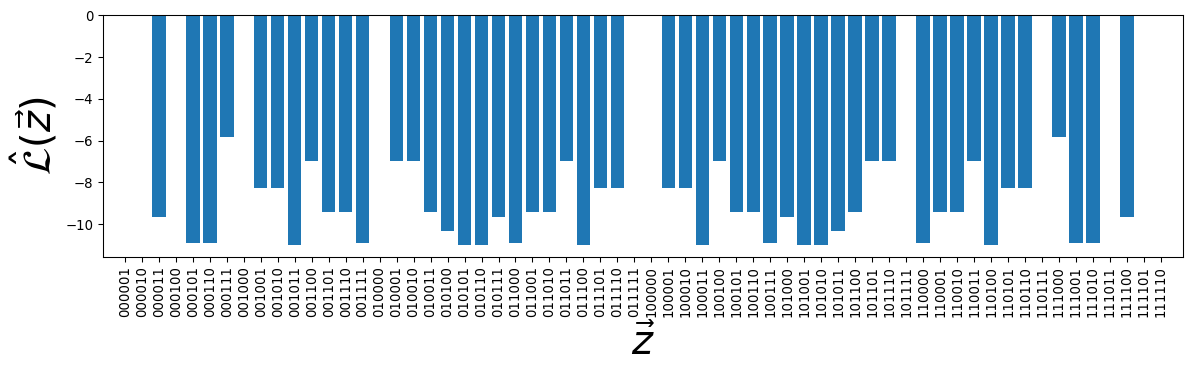

Max. Likelihood block asssignment (a,b,c,d,e,f) = 000001


In [17]:
#BOILERPLATE_CODE
plt.clf()
plt.figure(figsize=(15,4), dpi=96)
plt.bar(range(1,(2**n)-1), likelihoods, align='center')
# plt.yscale('log')
# plt.xlim([0,2**n])
# plt.ylim([10**-10,1])
x_ticks = ["{0:b}".format(i).zfill(n) for i in range(1,(2**n)-1)]
plt.xticks(range(1,2**n-1), x_ticks)
plt.ylabel(r'$\hat{\mathcal{L}}(\vec{z})$', fontsize=30)
plt.xlabel(r'$\vec{z}$', fontsize=30)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.25)
plt.subplots_adjust(left=0.15)
plt.show()

# Find z that maximises likelihood 
z_max = np.argmax(likelihoods)
z_max_vec = "{0:b}".format(1+z_max).zfill(n)
print("Max. Likelihood block asssignment (a,b,c,d,e,f) =", z_max_vec)

### Task 3: Block Model Inference in Empirical Network

Develop a simple heuristic optimisation algorithm to infer the optimal block assignment vector for a fixed number of blocks $B$ in an empirical social network. For this, you should first load the `highschool` network from the SQLite database file in the exercise repository as an undirected network.

In [18]:
#BOILERPLATE_CODE
import sqlite3

con = sqlite3.connect(r'./01_networks.db')
con.row_factory = sqlite3.Row

n_highschool = pp.Network.from_sqlite(con.execute('SELECT source, target FROM highschool'), directed=False)

2021-12-24 17:54:44 [Severity.INFO]	Retrieving links from database ...


The basic idea of the algorithm is to randomly change a random entry $z_i$ in the block assignment vector $\vec{z}$ by assigning $z_i$ a random number from $0$ to $B-1$ in each iteration. After each change you should recalculate the maximum likelihood of the new vector and keep the new vector if the change has increased the likelihood. Run this algorithm for 20000 iterations, starting with a vector randomly assigning nodes to $B=4$ blocks.